# Policy Gradients on HIV Simulator

As an example of using WhyNot for reinforcement learning. WhyNot presents a unified interface with the [OpenAI gym](https://github.com/openai/gym), which makes it easy to run sequential decision making experiments on simulators in WhyNot.

In this notebook we compare four different policies on the WhyNot HIV simulator: a neural network policy trained by policy gradient, a random policy, the no treatment policy, and the max treatment policy.
<br/><br/>

In [10]:
%load_ext autoreload
%autoreload 2

import whynot.gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

from scripts import utils as utils
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## HIV Simulator
The HIV simulator is a differential equation simulator based on

Adams, Brian Michael, et al. Dynamic multidrug therapies for HIV: Optimal and STI control approaches. North Carolina State University. Center for Research in Scientific Computation, 2004. APA.

This HIV model has a set of 6 state and 20 simulation parameters to parameterize the dynamics. 
The state variables are:
* uninfected_T1: uninfected CD4+ T-lymphocytes (cells/ml)
* infected_T1: infected CD4+ T-lymphocytes (cells/ml)
* uninfected_T2: uninfected macrophages (cells/ml)
* infected_T2: infected macrophages (cells/ml)
* free_virus: free virus (copies/ml)
* immune_response: immune response CTL E (cells/ml)


The simulator models two types of drugs: RT (reverse-transcriptase inhibitors) inhibitors and protease inhibitors. RT inhibitors are more effective on CD4+ T-lymphocytes (T1) cells, while protease inhibitors are more effective on macrophages (T2) cells.

There are 4 possible actions:
* Action 0: no drug, costs 0
* Action 1: protease inhibitor only, costs 1800
* Action 2: RT inhibitor only, costs 9800
* Action 3: both RT inhibitor and protease inhibitor, costs 11600

The reward at each step is defined based on the current state and the action. We follow the optimization objective introduced in the original paper by Adams et. al. Intuitively, virus is bad and immune response is good.

$$\text{reward} = -0.1 * \text{free}\_\text{virus} + 1000 * \text{immune}\_\text{response} - \text{action}\_\text{cost}$$

In [3]:
# Make the HIV environment and set random seed.
env = gym.make('HIV-v0')
np.random.seed(1)
env.seed(1)
torch.manual_seed(1)

## Compared Policies

### Base Policy Class
We define a base `Policy` class. Every policy has a `sample_action` function that takes an observation and returns an action.

### NNPolicy
A 1-layer feed forward neural network with state dimension as input dimension, one hidden layer of 8 neurons (the state dim is 6), and action dimension as output dimension. We use batch normalization and ReLU activation.

### No Treatment Policy
Never apply any treatment, i.e. action = 0 (corresponds to $\epsilon_1 = 0$ and $\epsilon_2 = 0$ in the simulation) for all observations.

### Max Treatment Policy
Never apply max treatment, i.e. action = 3 (corresponds to $\epsilon_1 = 0.7$ and $\epsilon_2 = 0.3$ in the simulation) for all observations.

### Random Policy
Takes a random action regardless of the obervation.

In [17]:
class NoTreatmentPolicy(utils.Policy):
    """The policy of always no treatment."""
    def __init__(self):
        super(NoTreatmentPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return 0
    
class MaxTreatmentPolicy(utils.Policy):
    """The policy of always applying both RT inhibitor and protease inhibitor."""
    def __init__(self):
        super(MaxTreatmentPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return 3
    
class RandomPolicy(utils.Policy):
    """The policy of picking a random action at each time step."""
    def __init__(self):
        super(RandomPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return np.random.randint(4)


## Policy Gradient Implementation Details
For a given state $s$, a policy can be written as a probability distribution $\pi_\theta(s, a)$ over actions $a$, where $\theta$ is the parameter of the policy.

The reinforcement learning objective is to learn a $\theta^*$ that maximizes the objective function

   $\;\;\;\; J(\theta) = E_{\tau \sim \pi_\theta}[r(\tau)]$,

where $\tau$ is the trajectory sampled according to policy $\pi_\theta$ and $r(\tau)$ is the sum of discounted rewards on trajectory $\tau$.

The policy gradient approach is to take the gradient of this objective

   $\;\;\;\; \nabla_\theta J(\theta) = \nabla_\theta \int \pi_\theta(\tau)r(\tau)d\tau = \int \pi_\theta(\tau) \nabla_\theta \log\pi_\theta(\tau)r(\tau)d\tau  = E_{\tau \sim \pi_\theta(\tau)}[\nabla_\theta \log \pi_\theta(\tau)r(\tau)]$

### Reward to Go
Here, $\log \pi_\theta(\tau) = \sum_{t=0}^T \log \pi_\theta(a_t \mid s_t)$ and $r(\tau) = \sum_{t=0}^T \gamma^t r_t$. Since the reward $r_t$ at time $t$ is not influenced by states and actions that happen after $t$, we can replace $ \log \pi_\theta(\tau)r(\tau)$ in the equation above by

  $\;\;\;\;\sum_{t=0}^T \log \pi_\theta(a_t \mid s_t) \; \gamma^t \sum_{t'=t}^T \gamma^{t'-t} r_{t'}$.
  
This technique is referred to as "reward to go". In practice, it often works better to omit the $\gamma^t$ factor. As a short hand, we will denote $\gamma^{t'-t} r_{t'}$ as $Q_t$. In a sense, $Q_t$ represents the "reward to go".

### Sampling

In practice this can be estimated by sampling trajectories $\tau^{(i)} = \{s_0^{(i)}, a_0^{(i)}, s_1^{(i)}, a_1^{(i)}, \cdots\} \sim \pi_\theta(\tau)$ and computing the gradient (w.r.t. $\theta$) of loss function

$\;\;\;\; Loss = -\frac{1}{N} \sum_i [\sum_{t=0}^T \log \pi_\theta(a_t^{(i)} \mid s_t^{(i)}) \;Q_t^{(i)}]$.

### Baseline and Advantage
In practice, for better stability in training, we demean the "reward to go" $Q_t$ by a baseline $b_t$. This can be a constant or a neural network function of the state. The demeaned quantity $A_t = Q_t - b_t$ is referred to ads "advantage", as it represents how much better the action is compared to average. We can also hope for better stability by normalizing the advantage by $\tilde A_t = (A_t - mean(A_t)) / std(A_t)$. 

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****
*****Iteration 150*****
*****Iteration 160*****
*****Iteration 170*****
*****Iteration 180*****
*****Iteration 190*****
*****Iteration 200*****
*****Iteration 210*****
*****Iteration 220*****
*****Iteration 230*****
*****Iteration 240*****
*****Iteration 250*****
*****Iteration 260*****
*****Iteration 270*****
*****Iteration 280*****
*****Iteration 290*****


//anaconda3/envs/whynot/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Attempting to set identical bottom == top == 101.0 results in singular transformations; automatically expanding.


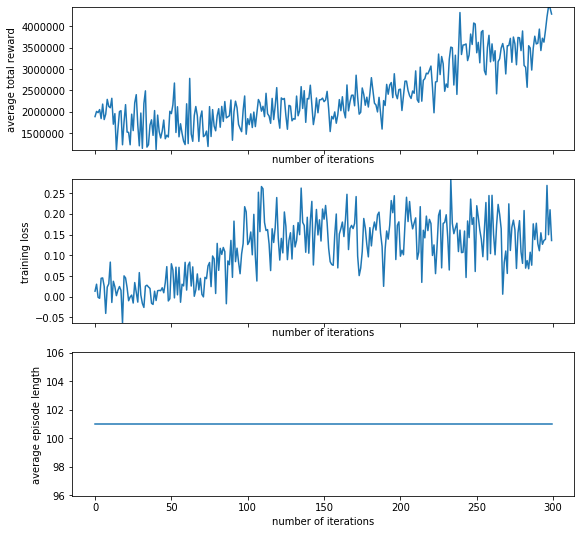

In [20]:
learned_policy = utils.run_training_loop(
    env=env, n_iter=300, max_episode_length=100, batch_size=1000, learning_rate=1e-3)

Total reward for learned_policy: 4802102.5
Total reward for no_treatment: 1762320.5
Total reward for max_treatment: 2147030.5
Total reward for random: 2171225.0


No handles with labels found to put in legend.


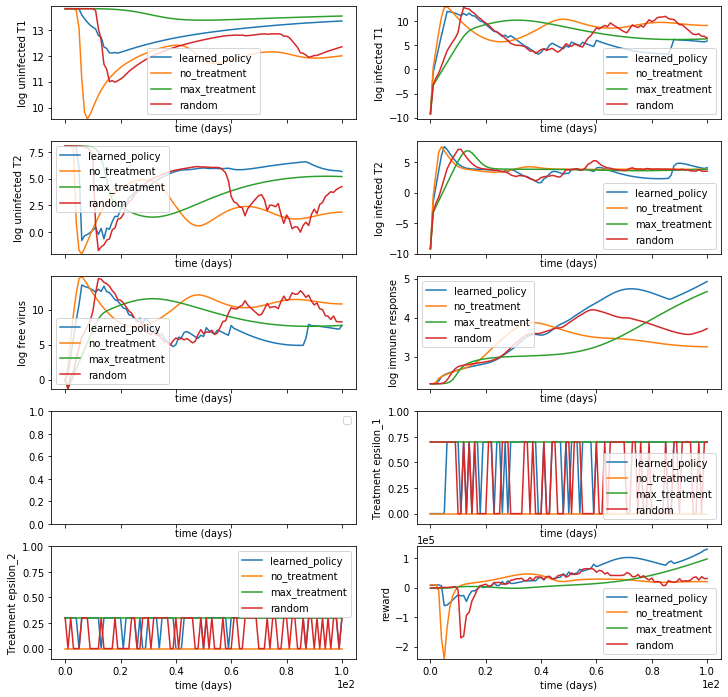

In [21]:
policies = {
    "learned_policy": learned_policy,
    "no_treatment": NoTreatmentPolicy(),
    "max_treatment": MaxTreatmentPolicy(),
    "random": RandomPolicy(),
}
utils.plot_sample_trajectory(policies, 100)

Note: To make sure the results are robust, we also try this with different random seeds. For example, to set 4 as the random seed, run:
```
np.random.seed(4)
env.seed(4)
torch.manual_seed(4)
```

The results are similar qualitatively but the exact rewards can vary from run to run based on the seed.